## make_circles
Make a large circle containing a smaller circle in 2d.

A simple toy dataset to visualize clustering and classification algorithms.

In [153]:
from sklearn.datasets import make_circles
X, y = make_circles(random_state=42) # generate 100 points by default
print(X.shape) # 100 (x,y) coordinates
print(y.shape) # 100 labels
list(y[:5])

(100, 2)
(100,)


[1, 1, 1, 0, 0]

# Prepare the classification data

In [154]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, # Uppercase X represents the feature matrix
                    noise=0.03,
                    random_state=42)

In [155]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


Visualize and put them into a pandas DataFrame

In [156]:
import pandas as pd
circles = pd.DataFrame({
    "X": X[:, 0],
    "Y": X[:, 1],
    "label": y
    })
circles.head()

,X,Y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [157]:
circles.label.value_counts() # check different labels

label
1    500
0    500
Name: count, dtype: int64

Visualize with a plot

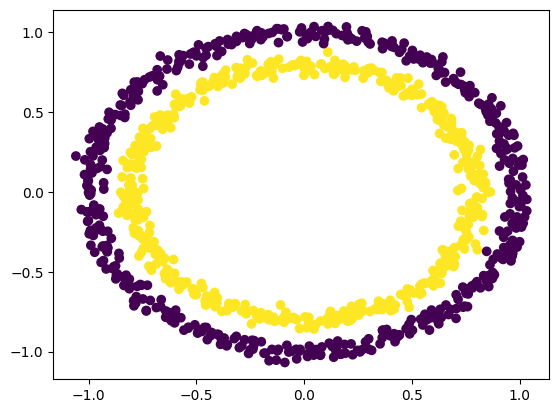

In [158]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
         y = X[:, 1],
         c = y)

## Input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations will result in errors in your models.

We're going to see plenty of these throughout the course.

And there's no surefire way to make sure they won't happen, they will.

What you can do instead is continually familiarize yourself with the shape of the data you're working with.

Ask yourself: "What shapes are my inputs and outputs?"

In [159]:
X.shape, y.shape

((1000, 2), (1000,))

View an example of features and labels

In [160]:
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


## Turn data into tensors and create train and test splits

In [161]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing nn.Module.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

In [163]:
from torch import nn

device = "mps" if torch.backends.mps.is_available else "cpu"
device

'mps'

Given X features, we want our model to predict y label.

In [164]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # having 5 hidden units
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self,x):
        return self.layer_2(self.layer_1(x))

**How to Select the Optimal Number of Hidden Units (a Hyperparameter)?**

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

In [165]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

We can also use nn.Sequntial()

In [166]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

However, it always runs in sequential order.

If you'd like something more than straight-forward sequential computation, you'll want to define your own custom nn.Module subclass.

In [167]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Set loss function and optimizer

Different problem types require different loss functions.

For a regression problem(predicting a number), you might use mean absolute error(MAE) loss.

For a binary classification problem, you will often use binary cross entropy as the loss function.

However, the same optimizer function can be used across different problem spaces.

| Loss function/Optimizer               | Problem type                          | PyTorch Code                              |
|----------------------------------------|---------------------------------------|-------------------------------------------|
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()`                       |
| Adam Optimizer                         | Classification, regression, many others. | `torch.optim.Adam()`                      |
| Binary cross entropy loss              | Binary classification                 | `torch.nn.BCEWithLogitsLoss` or `torch.nn.BCELoss` |
| Cross entropy loss                     | Multi-class classification            | `torch.nn.CrossEntropyLoss`               |
| Mean absolute error (MAE) or L1 Loss   | Regression                            | `torch.nn.L1Loss`                         |
| Mean squared error (MSE) or L2 Loss    | Regression                            | `torch.nn.MSELoss`                        |

A loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.

[The documentation for torch.nn.BCEWithLogitsLoss()](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

In [168]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), # params needs trainable nn.Parameter objects (from model_0.parameters()), while state_dict() returns a plain tensor dictionary.
                            lr = 0.1)

## Create an evaluation metric.

If a loss function measures how wrong the model is, then evaluation metrics measure how right it is.

Let's start with accuracy.

In [169]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

We can now use this function whilst training our model to measure it's preformance alongside the loss.

## Train model

Hint: PyTorch training loop steps

1. Forward pass
2. Calculate the loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Step the optimizer(gradient descent)

### From raw model outputs to predicted labels

In [170]:
# Before training, let's see what comes out of our model during the forward pass
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='mps:0', grad_fn=<SliceBackward0>)

In [171]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [172]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 1., 0., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [173]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Build a training and testing loop 

In [174]:
torch.manual_seed(42)

epochs = 100

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # training
    model_0.train() # turn on the training mode

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_0.eval()

    with torch.inference_mode():
        test_logit = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_fn(test_logit, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
    
    if epoch % 10 == 0:
        print(f"Epoch:{epoch}, Loss:{loss:.5f}, Accuracy:{acc:.2f} | Test Loss:{test_loss:.5f}, Test Accuracy:{test_acc:.2f}")

Epoch:0, Loss:0.69796, Accuracy:51.88 | Test Loss:0.69440, Test Accuracy:58.00
Epoch:10, Loss:0.69590, Accuracy:51.25 | Test Loss:0.69305, Test Accuracy:53.00
Epoch:20, Loss:0.69490, Accuracy:51.62 | Test Loss:0.69254, Test Accuracy:49.50
Epoch:30, Loss:0.69435, Accuracy:51.12 | Test Loss:0.69236, Test Accuracy:49.50
Epoch:40, Loss:0.69401, Accuracy:50.88 | Test Loss:0.69232, Test Accuracy:51.00
Epoch:50, Loss:0.69378, Accuracy:50.25 | Test Loss:0.69234, Test Accuracy:50.00
Epoch:60, Loss:0.69362, Accuracy:50.00 | Test Loss:0.69239, Test Accuracy:51.50
Epoch:70, Loss:0.69351, Accuracy:50.25 | Test Loss:0.69246, Test Accuracy:51.00
Epoch:80, Loss:0.69342, Accuracy:49.88 | Test Loss:0.69254, Test Accuracy:50.00
Epoch:90, Loss:0.69336, Accuracy:49.88 | Test Loss:0.69262, Test Accuracy:53.00


### Visualize

In [175]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


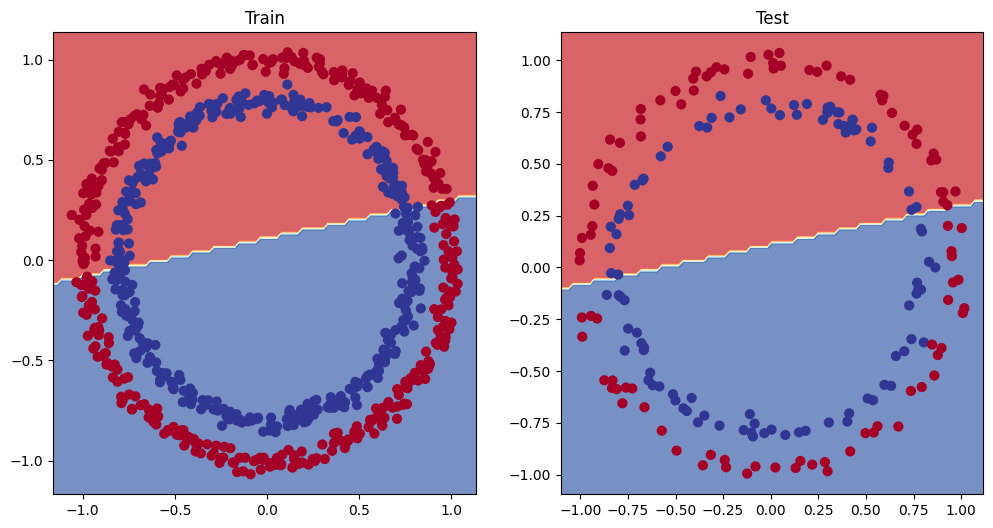

In [176]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The model performs like random guessing(about 50% accuracy).

A straight line cuts the circle exactly in half, splitting all its points into two even parts.

Our model is underfitting and it's not learning predictive patterns from the data.

### Improving a model

| Model improvement technique | What does it do? |
|------------------------------|------------------|
| Add more layers              | Boosts learning capacity (learns new data patterns); makes the network "deeper" |
| Add more hidden units        | Enhances learning capacity; makes the network "wider" |
| Fitting for longer (more epochs) | Lets the model interact with data more, potentially improving learning |
| Changing the activation functions | Uses non-linear functions to fit data that can’t be modeled with straight lines |
| Change the learning rate     | Controls parameter update magnitude: too large = overcorrection; too small = insufficient learning |
| Change the loss function     | Matches task needs (e.g., binary cross-entropy doesn’t work for multi-class tasks) |
| Use transfer learning        | Adapts pre-trained models from similar domains to your task (covered in notebook 06) |

There is no one-size-fits-all approach, best to follow the data scientists' motto of "experiment, experiment, experiment".

In [177]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [178]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [179]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [180]:
torch.manual_seed(42)
epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # training
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_preds, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_preds, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f"Epoch:{epoch}, Train Loss:{loss}, Test acc:{acc} | Test Loss:{test_loss}, Test acc:{test_acc}")

Epoch:0, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:100, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:200, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:300, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:400, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:500, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:600, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:700, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:800, Train Loss:0.7576878070831299, Test acc:50.875 | Test Loss:0.7554112076759338, Test acc:51.0
Epoch:900, Train Loss:0.7576878070831299, Test acc:50.875 | Test L

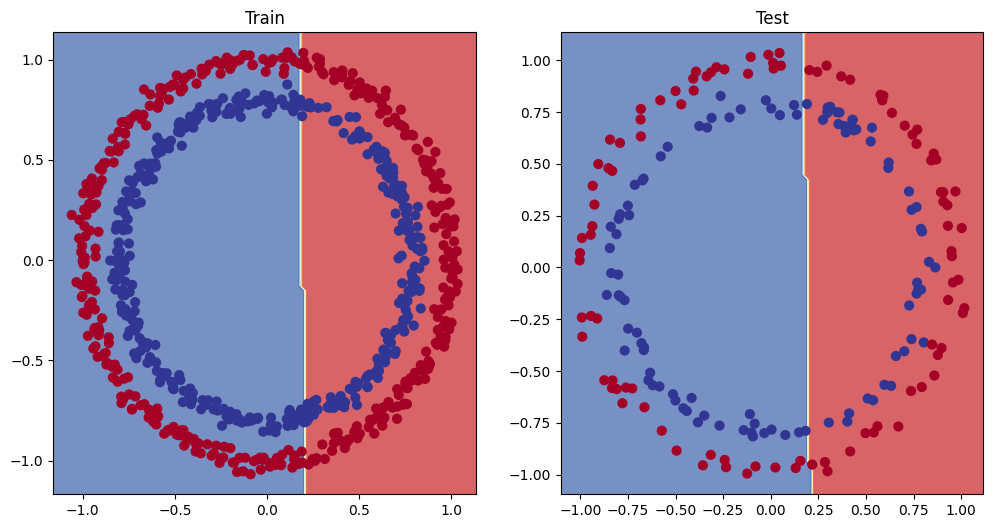

In [181]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Our model still draws a straight line between those dots.

### See if our model can model a straight line

In [182]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [183]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


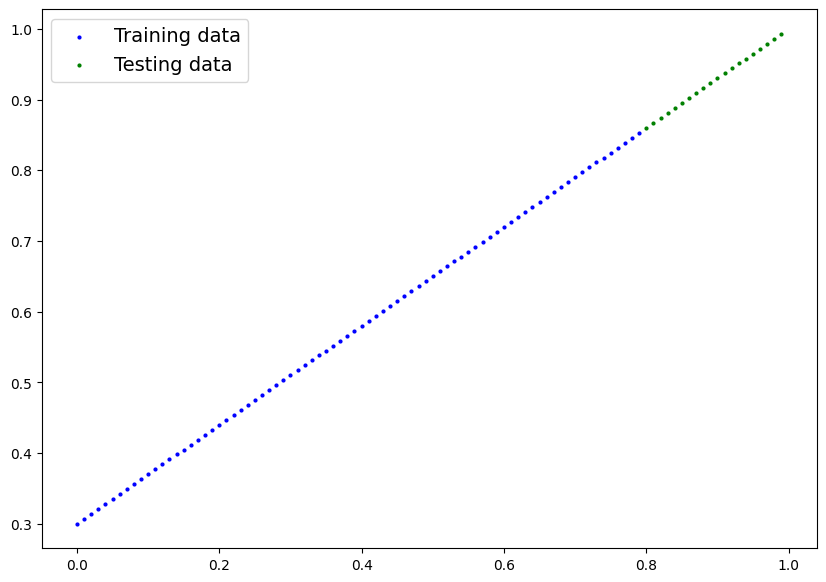

In [184]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels=y_test_regression)

In [185]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [186]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

We could write similar training and testing loop into a function. But we keep writing for practice.

In [187]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    # training
    model_2.train()
    y_preds = model_2(X_train_regression)
    loss = loss_fn(y_preds, y_train_regression)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
        test_loss = loss_fn(test_preds, y_test_regression)
    if epoch % 100 == 0:
        print(f"Epoch:{epoch}, Train Loss:{loss}, Test Loss:{test_loss}")

Epoch:0, Train Loss:0.7598585486412048, Test Loss:0.5414277911186218
Epoch:100, Train Loss:0.09308697283267975, Test Loss:0.029011746868491173
Epoch:200, Train Loss:0.07375665754079819, Test Loss:0.028500525280833244
Epoch:300, Train Loss:0.06745046377182007, Test Loss:0.006151759531348944
Epoch:400, Train Loss:0.061067190021276474, Test Loss:0.02003931812942028
Epoch:500, Train Loss:0.05698207765817642, Test Loss:0.010607662610709667
Epoch:600, Train Loss:0.04856663942337036, Test Loss:0.0132618872448802
Epoch:700, Train Loss:0.061086203902959824, Test Loss:0.021267995238304138
Epoch:800, Train Loss:0.05599402263760567, Test Loss:0.014255634509027004
Epoch:900, Train Loss:0.05571141466498375, Test Loss:0.006033620331436396


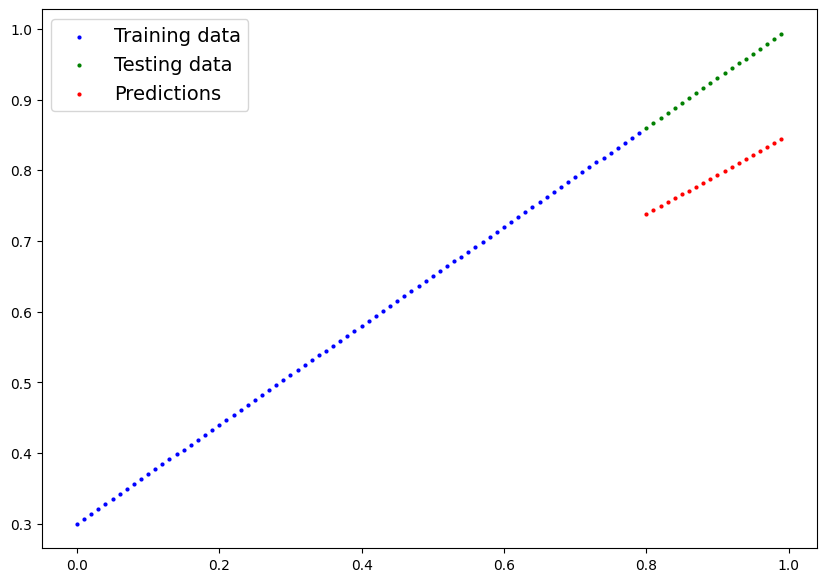

In [188]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(X_train_regression.cpu(),
                 y_train_regression.cpu(),
                 X_test_regression.cpu(),
                 y_test_regression.cpu(),
                 predictions=y_preds.cpu())

Our model can draw straight lines thanks to its linear layers.

Let's find out how to draw non-straight lines.

### Recreating non-linear dataset

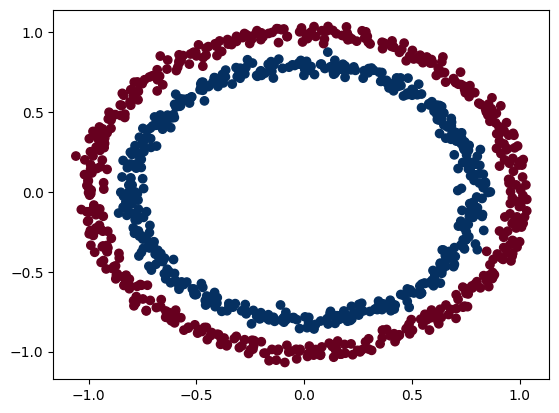

In [189]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [190]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

What introduce the capability of dealing with circles?

Non-linear activation functions.

- Without activation functions: linear transformations only → fit linear relationships (straight lines)

- With ReLU (non-linear activation): introduces non-linearity → fit non-linear patterns (circles)

In [191]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [192]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [193]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [194]:
torch.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # training
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train) # pass y_logits, rather than y_preds
    acc = accuracy_fn(y_train, y_preds) # y_preds are used to calculate acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_3.eval()
    
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 100 == 0:
        print(f"Epoch:{epoch}, Train Loss:{loss}, Train Acc:{acc} | Test Loss:{test_loss}, Test Acc:{test_acc}")

Epoch:0, Train Loss:0.6929462552070618, Train Acc:50.0 | Test Loss:0.6931881904602051, Test Acc:50.0
Epoch:100, Train Loss:0.691152811050415, Train Acc:52.87500000000001 | Test Loss:0.6910240054130554, Test Acc:52.5
Epoch:200, Train Loss:0.6897743940353394, Train Acc:53.37499999999999 | Test Loss:0.68939608335495, Test Acc:55.00000000000001
Epoch:300, Train Loss:0.6879494190216064, Train Acc:53.0 | Test Loss:0.6872316598892212, Test Acc:56.00000000000001
Epoch:400, Train Loss:0.6851678490638733, Train Acc:52.75 | Test Loss:0.6841148138046265, Test Acc:56.49999999999999
Epoch:500, Train Loss:0.6810224652290344, Train Acc:52.75 | Test Loss:0.6794120073318481, Test Acc:56.49999999999999
Epoch:600, Train Loss:0.6751485466957092, Train Acc:54.50000000000001 | Test Loss:0.6728507280349731, Test Acc:56.00000000000001
Epoch:700, Train Loss:0.6665886044502258, Train Acc:58.375 | Test Loss:0.6632164120674133, Test Acc:59.0
Epoch:800, Train Loss:0.6515954732894897, Train Acc:64.0 | Test Loss:0.64

That's better!

In [195]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_test)
    y_preds = torch.round(torch.sigmoid(y_logits))
y_preds[:10], y[:10]

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

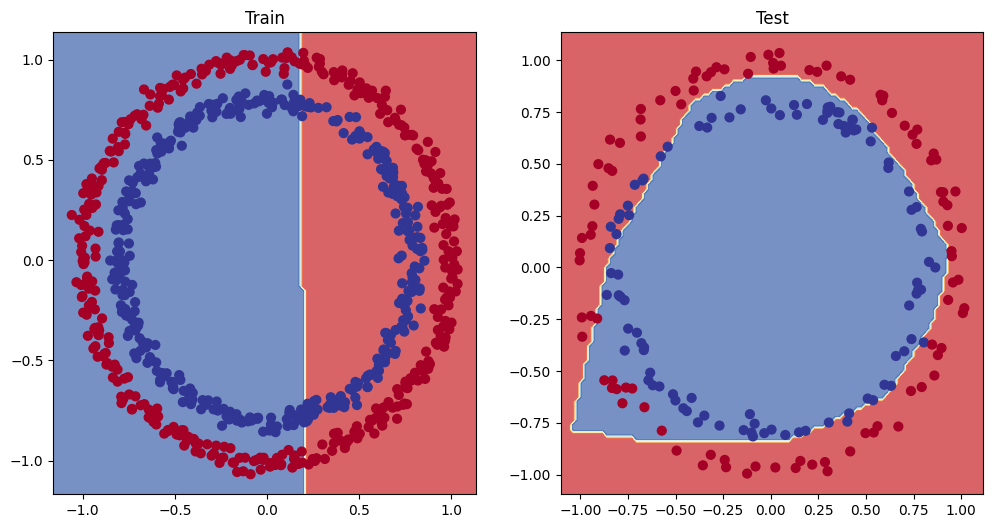

In [196]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

### Two different activation functions

In [197]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

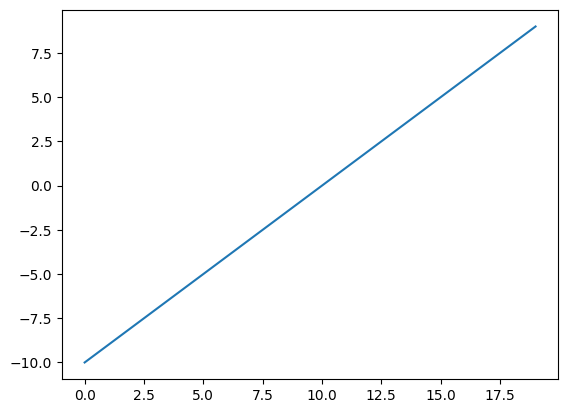

In [198]:
plt.plot(A)

Let's see how the ReLU activation influences it.

In [200]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

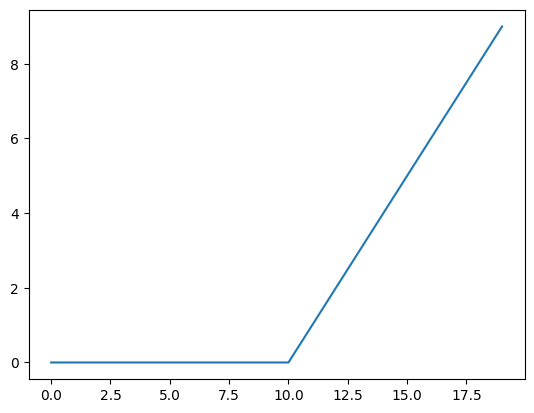

In [201]:
plt.plot(relu(A))

In [202]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

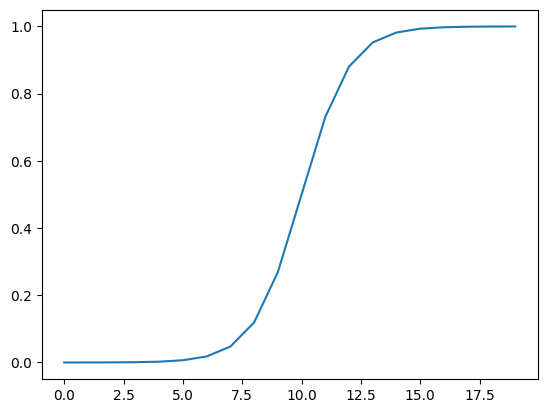

In [205]:
plt.plot(sigmoid(A))

## Multi-class classification task

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


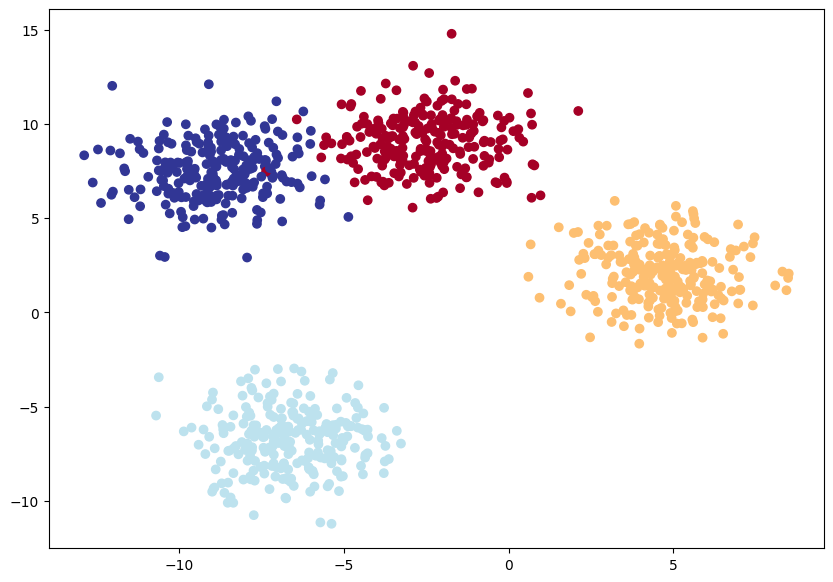

In [ ]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
# X_blob is the feature matrix, and y_blob is the label array.

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, train_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu)

In [213]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features))
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [216]:
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [217]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [218]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.5964e+00,  1.7347e+00,  1.3694e+00, -8.7214e-02],
        [ 7.8371e-01, -3.7279e-01,  1.7612e-02,  1.3865e-04],
        [-1.6647e+00,  1.9066e+00,  1.3526e+00, -4.2225e-02],
        [-3.8954e-01,  5.1871e-01,  7.5756e-01, -1.0582e-01],
        [-1.4653e+00,  1.6952e+00,  1.2568e+00, -4.9775e-02]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [219]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [ ]:
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
# To turn the logits into prediction probabilities, we use the softmax activation function.
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.3682, -0.9727, -0.2732, -0.0136],
        [-1.4148,  1.6694,  1.2186, -0.0398],
        [-1.4564,  2.6300,  0.7808,  0.3529],
        [ 1.0502, -0.4474, -0.2144,  0.0788],
        [ 0.4502, -0.4061,  0.3711, -0.1523]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.6489, 0.0625, 0.1257, 0.1630],
        [0.0246, 0.5365, 0.3418, 0.0971],
        [0.0132, 0.7832, 0.1233, 0.0803],
        [0.5306, 0.1187, 0.1498, 0.2009],
        [0.3453, 0.1467, 0.3190, 0.1890]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [227]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

In [ ]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0])) 
# The index of the highest value is the class this data sample belongs to.

tensor([0.6489, 0.0625, 0.1257, 0.1630], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='mps:0')


### Create a training and testing loop for a multi-class model

In [ ]:
torch.manual_seed(42)

epochs = 100

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # dim=0: represents the sample dimension
    # dim=1: represents the class dimension

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch:{epoch}, Train Loss:{loss:.5f}, Train Acc:{acc:.2f}% | Test Loss:{test_loss:.5f}, Test Acc:{test_acc:.2f}%")

Epoch:0, Train Loss:0.02073, Train Acc:99.50% | Test Loss:0.03330, Test Acc:99.00%
Epoch:10, Train Loss:0.02046, Train Acc:99.50% | Test Loss:0.03320, Test Acc:98.88%
Epoch:20, Train Loss:0.02022, Train Acc:99.50% | Test Loss:0.03311, Test Acc:98.88%
Epoch:30, Train Loss:0.02000, Train Acc:99.50% | Test Loss:0.03304, Test Acc:98.88%
Epoch:40, Train Loss:0.01979, Train Acc:99.50% | Test Loss:0.03298, Test Acc:98.88%
Epoch:50, Train Loss:0.01961, Train Acc:99.50% | Test Loss:0.03294, Test Acc:98.88%
Epoch:60, Train Loss:0.01943, Train Acc:99.50% | Test Loss:0.03290, Test Acc:98.88%
Epoch:70, Train Loss:0.01927, Train Acc:99.50% | Test Loss:0.03288, Test Acc:98.88%
Epoch:80, Train Loss:0.01912, Train Acc:99.50% | Test Loss:0.03286, Test Acc:98.88%
Epoch:90, Train Loss:0.01898, Train Acc:99.50% | Test Loss:0.03284, Test Acc:99.00%


### Visualize

In [233]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  8.9237,  18.2942, -15.7548, -10.6628],
        [  2.7679, -19.9754,   3.6050,  12.5060],
        [-13.8516, -26.6620,  25.6175,  16.0601],
        [  4.2104,  12.4389,  -8.2725,  -7.2378],
        [ 12.3623,   7.6950, -16.5576,  -4.0825],
        [  2.7032, -24.7559,   5.1794,  15.4225],
        [-13.4278, -21.3934,  23.4600,  12.8570],
        [  9.5381,   0.3034, -10.8584,   0.3405],
        [-15.5437, -35.7100,  30.4784,  21.5303],
        [ 10.3781,   2.9513, -12.6942,  -1.2494]], device='mps:0')

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 99.0%


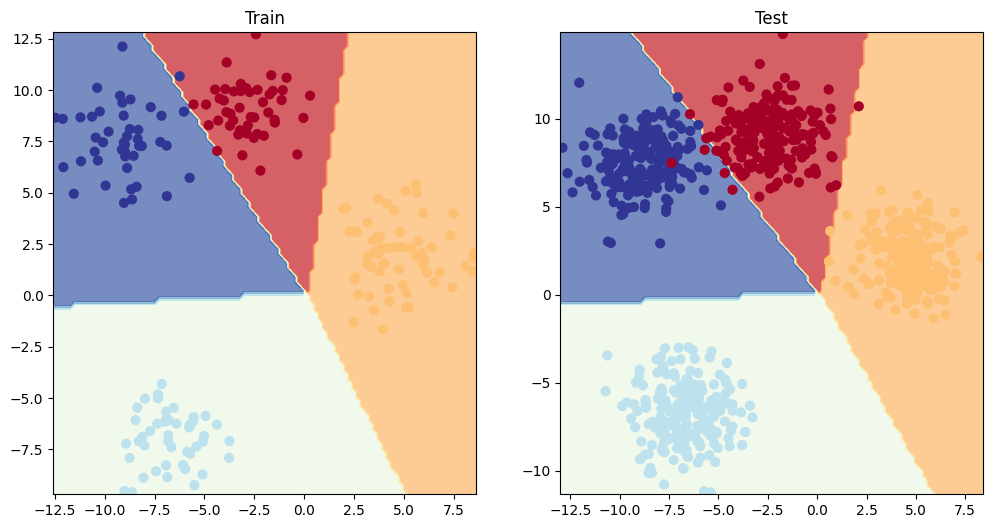

In [235]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## More classification evaluation metrics

| Metric/Method       | Definition                                                                 | Code (TorchMetrics / Scikit-learn) |
|---------------------|-----------------------------------------------------------------------------|-------------------------------------|
| Accuracy            | % of correct predictions                                                   | `torchmetrics.Accuracy()` / `sklearn.metrics.accuracy_score()` |
| Precision           | True positives / all predicted positives (↓ false positives)               | `torchmetrics.Precision()` / `sklearn.metrics.precision_score()` |
| Recall              | True positives / all actual positives (↓ false negatives)                  | `torchmetrics.Recall()` / `sklearn.metrics.recall_score()` |
| F1-score            | Precision + recall combined (0-1, 1=best)                                  | `torchmetrics.F1Score()` / `sklearn.metrics.f1_score()` |
| Confusion matrix    | Table: predicted vs. true values (correct = diagonal values)               | `torchmetrics.ConfusionMatrix` / `sklearn.metrics.plot_confusion_matrix()` |
| Classification report | Summary of precision/recall/F1 per class                                   | `sklearn.metrics.classification_report()` |

In [236]:
from torchmetrics import Accuracy

torchmetrics_acc = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetrics_acc(y_preds, y_blob_test)

tensor(0.9900, device='mps:0')